#Packs

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
from numpy import linalg as LA
import torch
import torch.nn as nn
from torch import optim
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import matplotlib.pyplot as plt
from scipy import stats

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    california = fetch_california_housing()
# Load the Boston dataset into a Pandas DataFrame
df = pd.DataFrame(california.data, columns=california.feature_names)
num_cols = df.select_dtypes(include=np.number).columns.tolist()



#Z-Score

In [2]:

# Compute the z-score for each value in the numerical columns
z_scores = np.abs(stats.zscore(df[num_cols]))

# Set a threshold for z-score
z_threshold = 1.5

# Find the rows with outliers in any of the numerical columns
outlier_rows = np.where(z_scores > z_threshold)[0]

# Remove the outlier rows from the DataFrame
df = df.drop(outlier_rows)

# Reset the index of the DataFrame
df = df.reset_index(drop=True)


#Feature Engineering

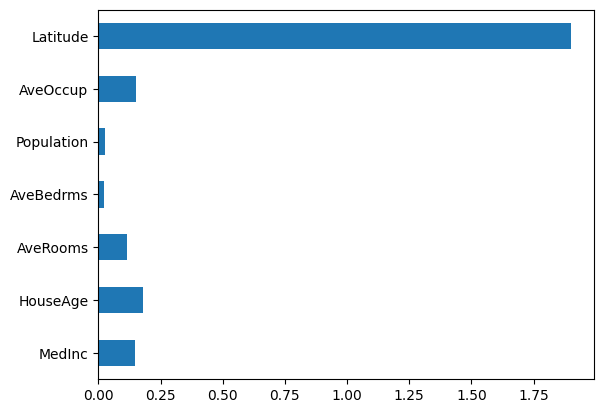

In [3]:
y = df.Longitude
X = df.drop("Longitude", axis=1)
mi_scores = mutual_info_regression(X, y)
feat_importances=pd.Series(mi_scores,X.columns[0:len(X.columns)])
feat_importances.plot(kind='barh')
plt.show()
X_featured=X.drop(["AveRooms","Population"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X_featured, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)


X_train=scaler.fit_transform(X_train)

X_test=scaler.transform(X_test)

X_val=scaler.transform(X_val)

X_train=np.array(X_train)
X_test=np.array(X_test)
X_val=np.array(X_val)
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)
#
X_train=torch.from_numpy(X_train).float()
X_test=torch.from_numpy(X_test).float()
y_train=torch.from_numpy(y_train).float()
y_test=torch.from_numpy(y_test).float()
X_val=torch.from_numpy(X_val).float()
y_val=torch.from_numpy(y_val).float()
y_test_reshaped = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)


#Linear regression

In [4]:
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(5, 1, bias = True) # bias is default True

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
our_model = LinearRegression()
criterion = torch.nn.MSELoss()

#LBFGS optimizer

Iteration 0: train_loss = 14156.9677734375, val_loss = 14142.4833984375
Iteration 10: train_loss = 0.34916359186172485, val_loss = 0.3589567542076111
Iteration 20: train_loss = 0.34916359186172485, val_loss = 0.3589567542076111


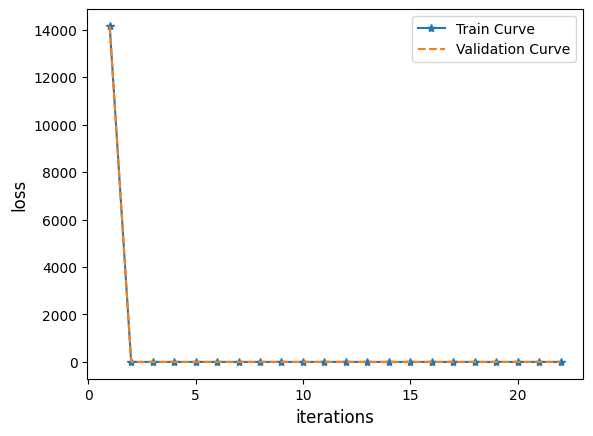

The MSE of the test is: 0.36674177646636963
The norm at critic point is: 5.035273716202937e-06


In [11]:
from torch.optim import LBFGS
import torch

model_LBFGS = LinearRegression()

train_loss = []
val_loss = []
optimizer_LBFGS = LBFGS(model_LBFGS.parameters(), max_iter=1240, lr=1)

     # Reshape y_train and y_val to have size (n_samples, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

     # Define the closure function for training set
def train_closure():

  optimizer_LBFGS.zero_grad()
  output = model_LBFGS(X_train)
  loss_bfgs = criterion(output, y_train)
  loss_bfgs.backward()
  return loss_bfgs

     # Define the closure function for validation set
def val_closure():

  output = model_LBFGS(X_val)
  loss_bfgs = criterion(output, y_val)
  return loss_bfgs

iteration_number =22

     # Train the model

for i in range(iteration_number):
    train_loss.append(train_closure().item())
    # Evaluate the model on validation set
    with torch.no_grad():
        loss_val = val_closure().item()
        val_loss.append(loss_val)
        loss = optimizer_LBFGS.step(train_closure)
    if i % 10 == 0:

        print("Iteration {}: train_loss = {}, val_loss = {}".format(i, train_loss[-1], loss_val,))






    #  Plot the learning curve
alpha = np.linspace(1, iteration_number, iteration_number)
plt.plot(alpha, train_loss, label='Train Curve',marker="*")

plt.plot(alpha, val_loss, label='Validation Curve', linestyle='dashed')

plt.xlabel('iterations', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend()
plt.show()
print("The MSE of the test is:", criterion(model_LBFGS(X_test),y_test_reshaped).item())
grad_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()) for p in model_LBFGS.parameters()]))
print("The norm at critic point is:", grad_norm.item())


#SGD optimizer

Iter 0, train_loss 14337.943359375, val_loss 9164.69921875
Iter 5, train_loss 1539.8150634765625, val_loss 984.5629272460938
Iter 10, train_loss 165.6527862548828, val_loss 106.04891204833984
Iter 15, train_loss 18.100099563598633, val_loss 11.70804500579834
Iter 20, train_loss 2.2555646896362305, val_loss 1.577762246131897
Iter 25, train_loss 0.553960382938385, val_loss 0.4899653196334839
Iter 30, train_loss 0.37117505073547363, val_loss 0.37310630083084106
Iter 35, train_loss 0.35153329372406006, val_loss 0.36052197217941284
Iter 40, train_loss 0.34941932559013367, val_loss 0.3591485619544983


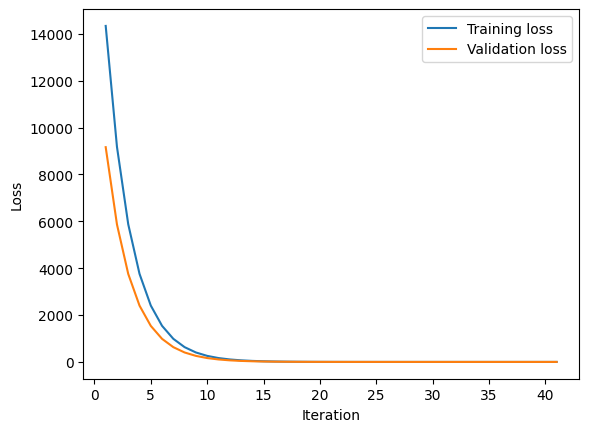

The MSE of the test is: 0.3673471212387085


In [6]:
def loveSGD():

    model_sgd = LinearRegression()
    iter = 41

    optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.1)

    losses_sgd = []
    val_losses_sgd = []
    for i in range(iter):
        # Train the model on the training set
        optimizer_sgd.zero_grad()
        y_pred = model_sgd(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer_sgd.step()
        losses_sgd.append(loss.item())

        # Evaluate the model on the validation set
        with torch.no_grad():
            y_val_pred = model_sgd(X_val)
            val_loss = criterion(y_val_pred, y_val)
            val_losses_sgd.append(val_loss.item())

        if i % 5 == 0:
            print('Iter {}, train_loss {}, val_loss {}'.format(i, loss.item(), val_loss.item()))

    # Plot the loss curves
    plt.plot(range(1, iter + 1), losses_sgd, label='Training loss')
    plt.plot(range(1, iter + 1), val_losses_sgd, label='Validation loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    print("The MSE of the test is:", criterion(model_sgd(X_test),y_test_reshaped).item())

loveSGD()


#Gradient Descent

In [10]:
# Initialize weights and bias
rng = np.random.RandomState(42)
init = rng.randint(100, size=(len(X_train[0])+1))
w = init[:len(init)-1] / 100
b = init[-1] / 100
w = w.reshape(-1, 1)
temp=X_train
temp_target=y_train
temp = temp.numpy()
temp_target = temp_target.numpy()

def y_pred(x, w, b):
    return np.matmul(x, w) + b

def loss(x, w, b, y_actual):
    return ((y_pred(x, w, b) - y_actual) ** 2).mean()

def grad(x, w, b, y_actual):
    dw = (2/x.shape[0]) * np.matmul(x.T, (y_pred(x, w, b) - y_actual))
    db = (2/x.shape[0]) * np.sum(y_pred(x, w, b) - y_actual)
    return dw, db

# Define the learning rate and number of epochs
learning_rate = 0.01
num_epochs = 401

# Implement gradient descent
for epoch in range(num_epochs):
    # Calculate the gradients for weights and bias
    dw, db = grad(temp, w, b, temp_target)

    # Update the weights and bias
    w = w - learning_rate * dw.reshape(-1, 1)
    b = b - learning_rate * db

    # Calculate the loss function
    loss_value = loss(temp, w, b, temp_target)

    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value:.4f}")


Epoch 0, Loss: 13727.3581
Epoch 100, Loss: 241.8654
Epoch 200, Loss: 4.6030
Epoch 300, Loss: 0.4244
Epoch 400, Loss: 0.3505
